In [1]:
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
%load_ext autoreload
%autoreload 2
import pei.myfunctions as mf
from xhistogram.xarray import histogram
from dask.diagnostics import ProgressBar

# Load Data

In [2]:
# Load binned WBT data
ds = xr.open_dataset('../data/processed/WBT_binned.nc')

# Plot Time Series for Three Thresholds

In [36]:
def plot_thres3(region,ds,ax):
    # Get data for region
    ds_region = ds[region]
    
    # Normalize data to get PDF, then make a percent
    ds_region = 100*ds_region/ds_region.sum(['WBT_bin','ensemble'])
    
    # Plot fraction of days per year above threshold temperatures
    ds_region.sel(WBT_bin=slice(25,None)).sum(['WBT_bin','ensemble']).plot(ax=ax)
    ds_region.sel(WBT_bin=slice(27.9,None)).sum(['WBT_bin','ensemble']).plot(ax=ax)
    ds_region.sel(WBT_bin=slice(30,None)).sum(['WBT_bin','ensemble']).plot(ax=ax)

    ax.set_xlabel('Year')
    ax.set_ylabel('% of Days in Year')
    ax.set_title('Percent of Days With Maximum WBT Above Threshold Values: '+region)
    ax.legend(['25   $^\circ$C','27.9$^\circ$C','30   $^\circ$C'],loc='upper left')
    #fig.savefig(region+'thres.png')

# Side-by-Side Plots

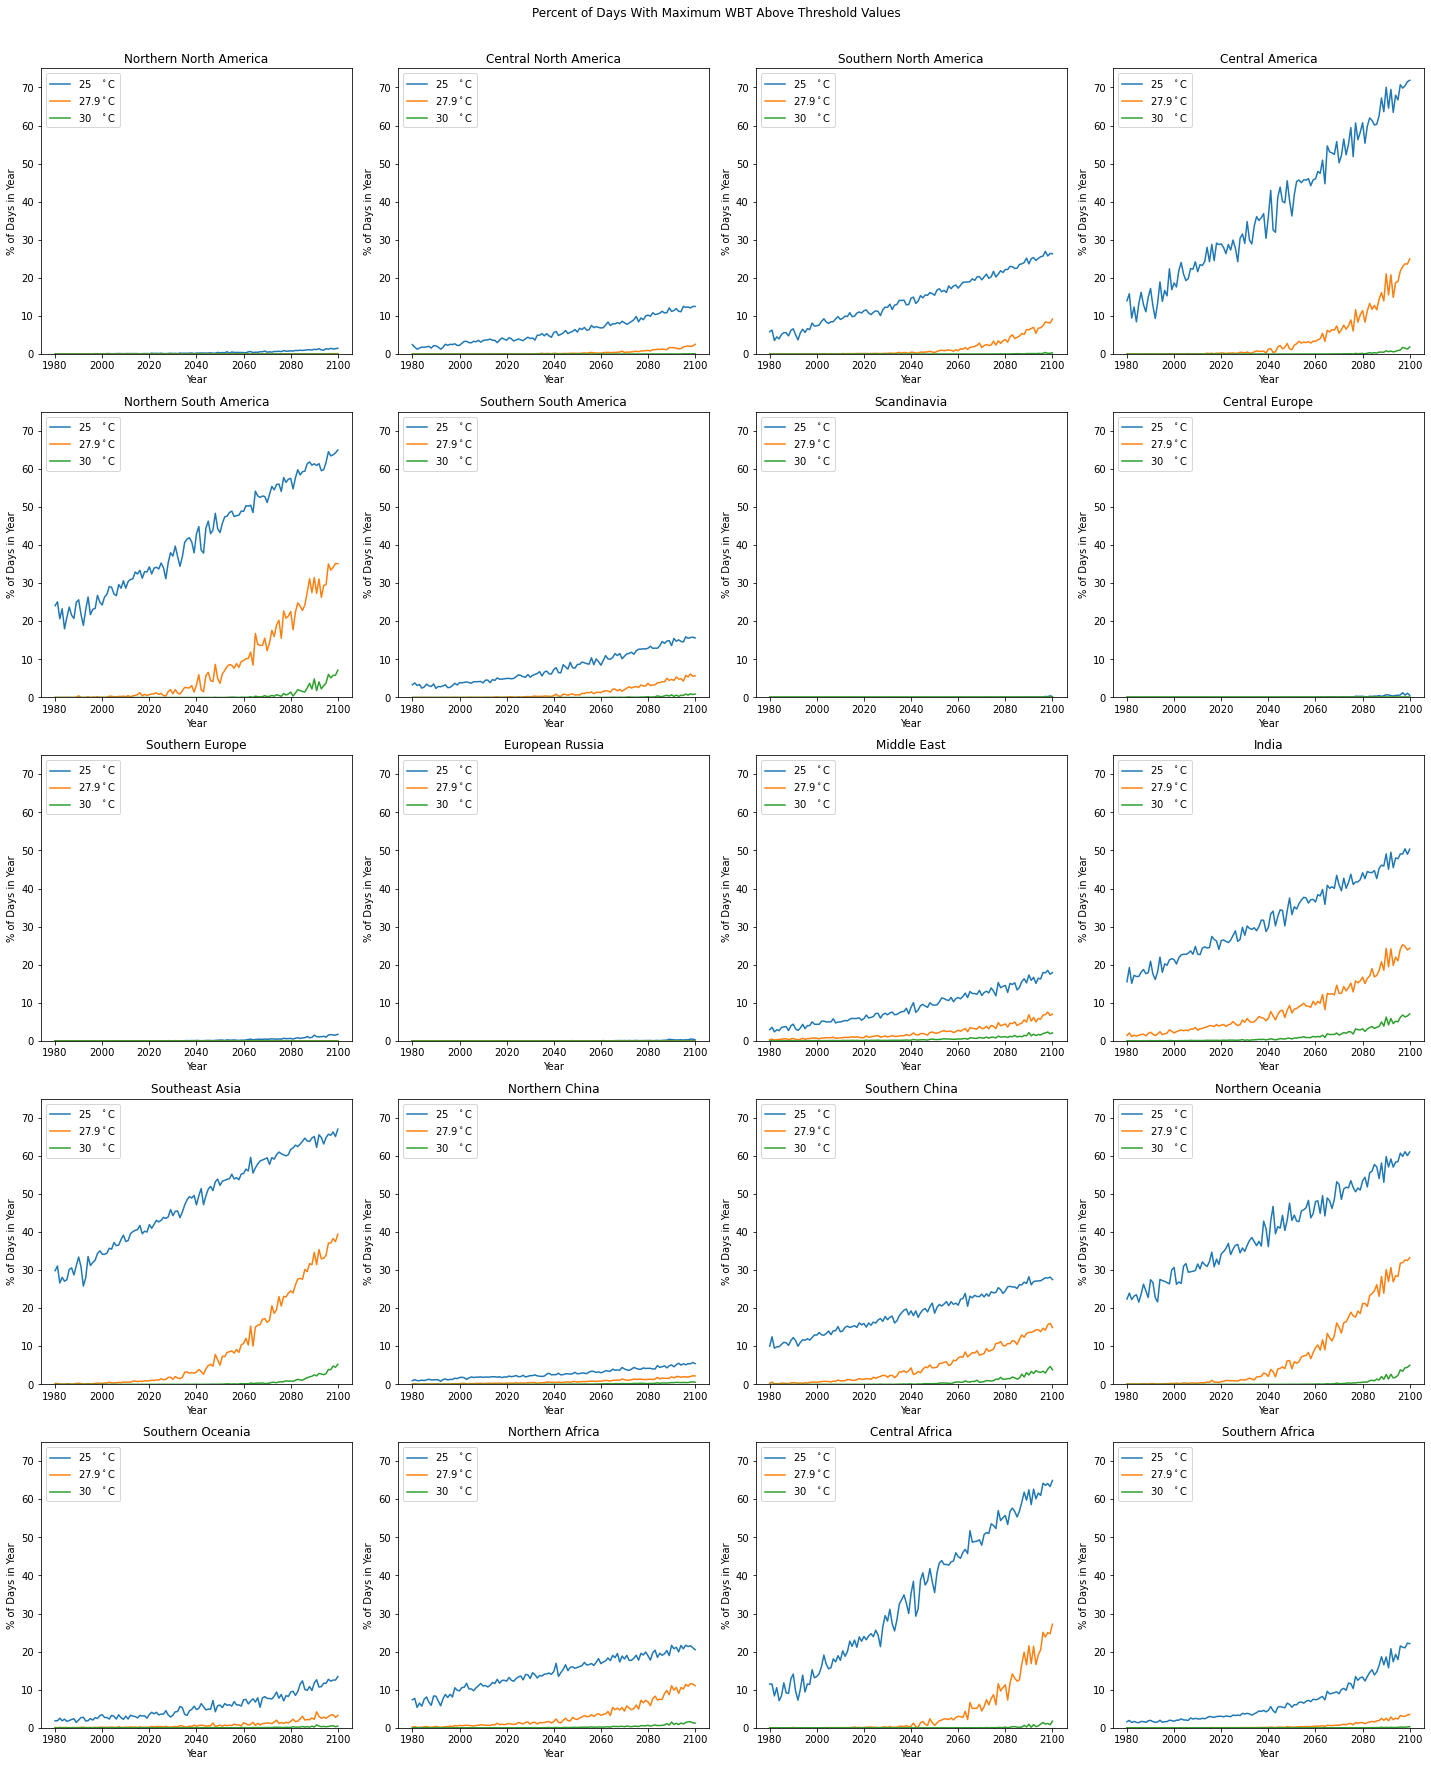

In [40]:
regions = ['Northern North America','Central North America','Southern North America',
          'Central America','Northern South America','Southern South America',
          'Scandinavia','Central Europe','Southern Europe','European Russia',
          'Middle East','India','Southeast Asia','Northern China','Southern China',
          'Northern Oceania','Southern Oceania',
          'Northern Africa','Central Africa','Southern Africa']

# Create figure and axes
fig, axs = plt.subplots(figsize=(20,24),nrows=5,ncols=4)

# Running counter to determine axis
index = 0

# Loop through regions
for region in regions:
    # Get correct axis
    ax = axs[int(index/4)][index%4]
    index+=1
    
    plot_thres3(region,ds,ax)
    ax.set_ylim(0,75)
    ax.set_title(region)
    
fig.suptitle('Percent of Days With Maximum WBT Above Threshold Values',y=1.02)
plt.tight_layout()

# Side-by-Side Plots, Cold Regions

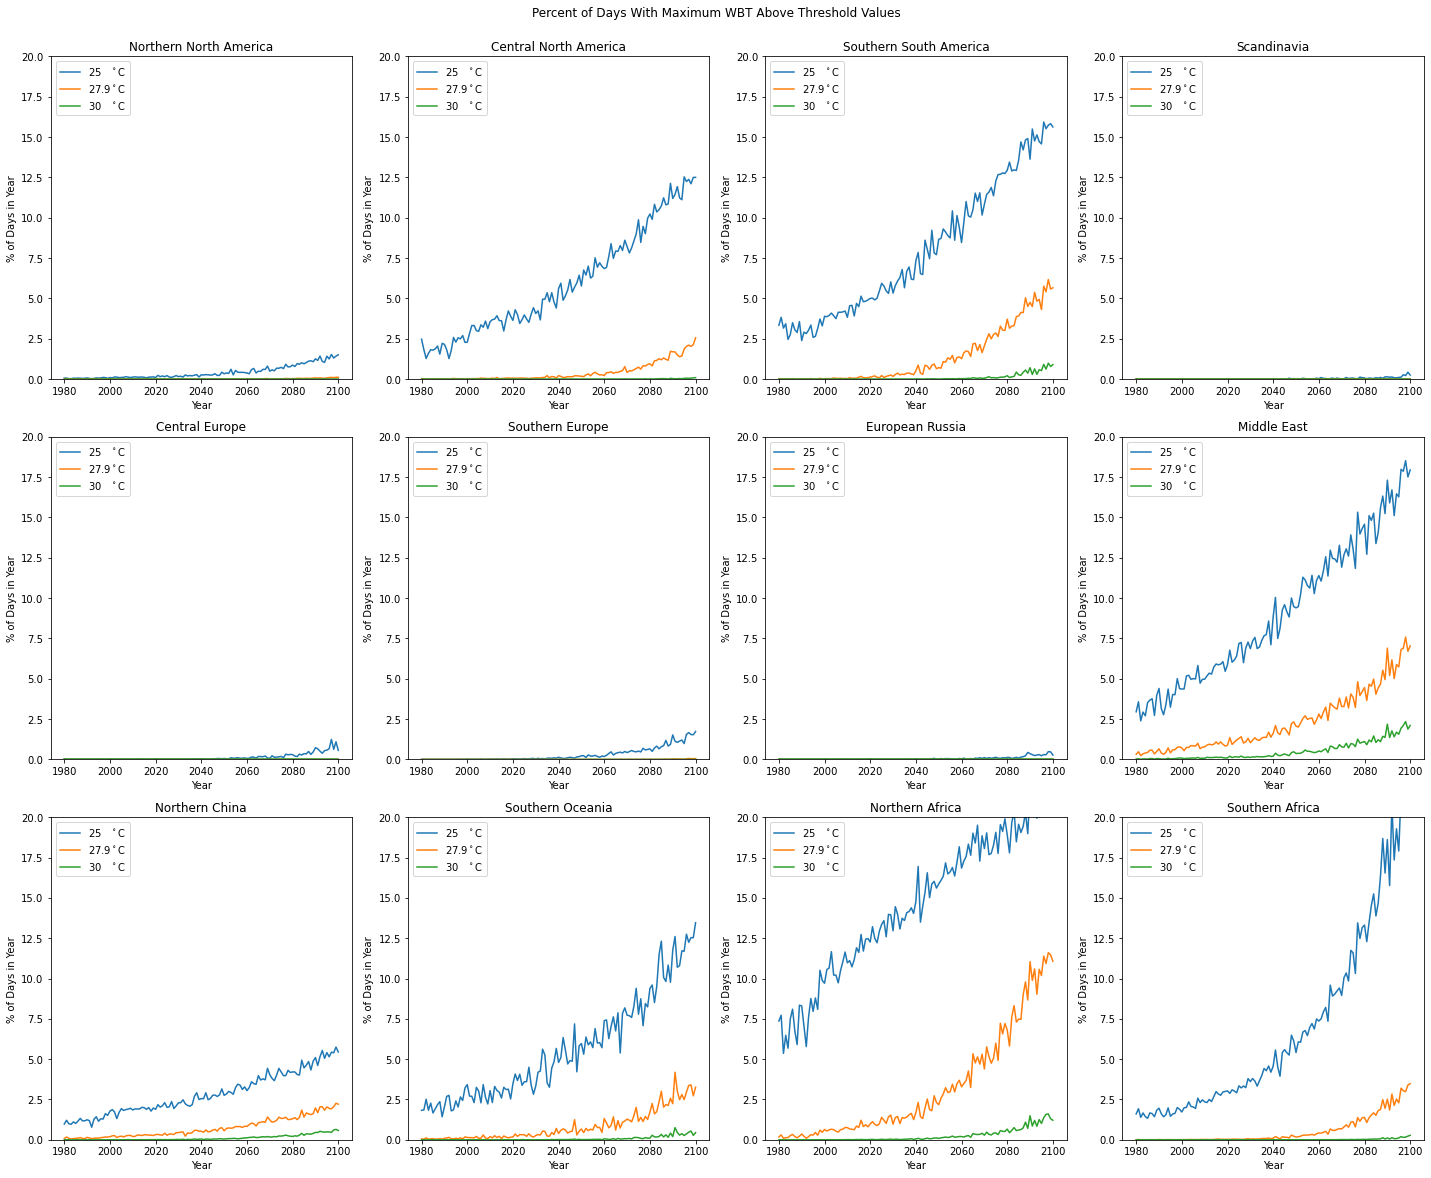

In [44]:
regions = ['Northern North America','Central North America',
          'Southern South America','Scandinavia','Central Europe','Southern Europe','European Russia',
          'Middle East','Northern China','Southern Oceania',
          'Northern Africa','Southern Africa']

# Create figure and axes
fig, axs = plt.subplots(figsize=(20,16),nrows=3,ncols=4)

# Running counter to determine axis
index = 0

# Loop through regions
for region in regions:
    # Get correct axis
    ax = axs[int(index/4)][index%4]
    index+=1
    
    plot_thres3(region,ds,ax)
    ax.set_ylim(0,20)
    ax.set_title(region)
    
fig.suptitle('Percent of Days With Maximum WBT Above Threshold Values',y=1.02)
plt.tight_layout()